# Perform POI Analysis with three OD Matrices

1. Benchmark the accessiblity measure from Rafa's research, but use the three OD matrices respectively;
2. Analyze the implications of methodology differences from three APIs.

## Step 1. Import libararies and load data

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point

# Mapping the MSOA

import folium
from folium.plugins import PolyLineTextPath
from folium.plugins import FeatureGroupSubGroup

import matplotlib.colors as colors
import matplotlib.cm as cm
import branca.colormap as branca_cm

import contextily as ctx


### Load the data:

In [2]:
# load TTMs
r5TTM = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/ttm_r5py_nan_handled.csv', encoding='latin1')

hereTTM = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/here_routing_matrix_format.csv', encoding='latin1')
# osrm not in mattrix format yet!
osrm_TTM = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_od_mat_all/osrmTTM.csv', encoding='latin1')

# make the first column the index:
r5TTM.set_index('originID', inplace=True)
hereTTM.set_index('originID', inplace=True)
osrm_TTM.set_index('origin_msoaID', inplace=True)

# times 60 for all elements in the matrix
r5TTM = r5TTM * 60

# MSOA Coordinates Lookup Table
msoa_london = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/msoa/processed/gld_msoa_centroids.csv', encoding='latin1')
# see if the column msoa21cd is unique:
msoa_london['msoa21cd'].nunique() == msoa_london.shape[0]

# follow this format: [{"lat": ..., "lng": ...}, ...]

# new dict origin: 1002 maoas
all_MSOA_coord_dict = {}

# for reference dict, read the msoa_london, use msoa21cd as key, lat and lon as value:
for i in range(msoa_london.shape[0]):
    msoaID = msoa_london.iloc[i, 3]
    lat = msoa_london.iloc[i, 8]
    lon = msoa_london.iloc[i, 9]
    #origin_coord.append({"lat": lat, "lng": lon})
    all_MSOA_coord_dict[msoaID] = {"lat": lat, "lng": lon}
all_MSOA_coord_df = pd.DataFrame(all_MSOA_coord_dict).T
all_MSOA_coord_df = all_MSOA_coord_df.reset_index()

all_MSOA_coord_df.columns = ['id', 'lat', 'lon']

all_MSOA_coord_df['geometry'] = all_MSOA_coord_df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
all_MSOA_gdf = gpd.GeoDataFrame(all_MSOA_coord_df, geometry='geometry')
all_MSOA_gdf.set_crs(epsg=4326, inplace=True)  

,id,lat,lon,geometry
0,E02000318,51.488265,0.095618,POINT (0.09562 51.48827)
1,E02000388,51.483157,-0.198445,POINT (-0.19845 51.48316)
2,E02000652,51.415041,-0.138046,POINT (-0.13805 51.41504)
3,E02000963,51.529079,-0.209371,POINT (-0.20937 51.52908)
4,E02000651,51.419153,-0.125942,POINT (-0.12594 51.41915)
...,...,...,...,...
997,E02000481,51.558124,0.293234,POINT (0.29323 51.55812)
998,E02000885,51.512556,-0.053381,POINT (-0.05338 51.51256)
999,E02000674,51.441193,-0.001961,POINT (-0.00196 51.44119)
1000,E02000975,51.514949,-0.179854,POINT (-0.17985 51.51495)


## Step 2. Select the POI and Perform Accessibility Analysis

Here we select GP and Hospital Access.



In [4]:
# read the pbf file:
osm_file = r'/mnt/d/Downloads/greater-london-latest.osm.pbf'
#london_geo_fabric = gpd.read_file(osm_file, layer='multipolygons')

In [6]:
import osmium

# Class to collect hospital information
class HospitalHandler(osmium.SimpleHandler, hos_or_gp):

    
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.hospitals_found = False  # Flag to track if any hospitals were found

    def node(self, n):
        if 'amenity' in n.tags and n.tags['amenity'] == 'hospital':
            print(f"Found Hospital: {n.tags.get('name', 'Unnamed')}, ID: {n.id}, Location: ({n.location.lat}, {n.location.lon})")
            self.hospitals_found = True

    def way(self, w):
        if 'amenity' in w.tags and w.tags['amenity'] == 'hospital':
            print(f"Found Hospital: {w.tags.get('name', 'Unnamed')}, ID: {w.id}")
            for node in w.nodes:
                print(f"    Node: {node.ref}, Location: ({node.location.lat}, {node.location.lon})")
            self.hospitals_found = True

 # Replace with your actual filename

# Process the PBF file
handler = HospitalHandler()
handler.apply_file(osm_file, locations=True)  # Ensure locations are loaded

# Check if any hospitals were found
if not handler.hospitals_found:
    print("No hospitals found in the PBF file.")

Found Hospital: National Hospital for Neurology and Neurosurgery, ID: 60660743, Location: (51.5222325, -0.1223623)
Found Hospital: Priory Hospital, ID: 254005151, Location: (51.6320636, -0.1183042)
Found Hospital: Bridge Lane Health Centre, ID: 289563831, Location: (51.4732684, -0.1663173)
Found Hospital: Royal Home and Hospital for Incurables, ID: 296563324, Location: (51.423089, -0.1070682)
Found Hospital: Chelsfield Park Hospital, ID: 444635673, Location: (51.3582569, 0.1316749)
Found Hospital: Sloane Hospital, ID: 637882835, Location: (51.4082042, -0.0045395)
Found Hospital: Queen Mary's Childrens' Hospital, ID: 1131534975, Location: (51.3797984, -0.1848418)
Found Hospital: Chapel Orchard Day Surgery, ID: 1971677516, Location: (51.4020487, -0.1715368)
Found Hospital: UCL Institute of Orthopaedics and Musculoskeletal Science, ID: 2313659997, Location: (51.6312434, -0.3074425)
Found Hospital: The Portland Hospital for Women and Children, ID: 2778453137, Location: (51.5224709, -0.1435

In [7]:
# Class to collect hospital or GP information
class AmenityHandler(osmium.SimpleHandler):

    def __init__(self, amenity_type='hospital'):
        osmium.SimpleHandler.__init__(self)
        self.amenity_type = amenity_type
        self.amenities_found = False  # Flag to track if any amenities were found

    def node(self, n):
        if 'amenity' in n.tags and n.tags['amenity'] == self.amenity_type:
            print(f"Found {self.amenity_type.capitalize()}: {n.tags.get('name', 'Unnamed')}, ID: {n.id}, Location: ({n.location.lat}, {n.location.lon})")
            self.amenities_found = True

    def way(self, w):
        if 'amenity' in w.tags and w.tags['amenity'] == self.amenity_type:
            print(f"Found {self.amenity_type.capitalize()}: {w.tags.get('name', 'Unnamed')}, ID: {w.id}")
            for node in w.nodes:
                print(f"    Node: {node.ref}, Location: ({node.location.lat}, {node.location.lon})")
            self.amenities_found = True

In [8]:
# Process the PBF file
amenity_type = 'general_practitioner'  # Change to 'hospital' if you need to find hospitals
handler = AmenityHandler(amenity_type)
handler.apply_file(osm_file, locations=True) 



ValueError: DataFrame constructor not properly called!

In [9]:
# save the hospital and GP data
gp_df = pd.DataFrame(handler.amenities)

AttributeError: 'AmenityHandler' object has no attribute 'amenities'

In [12]:
handler

AttributeError: 'AmenityHandler' object has no attribute 'amenities'

seems to be a bit messy, need to read in the hospital data

In [13]:
eng_hospitals = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/hopsital_locations_england.csv', encoding='latin1')

In [14]:
msoa_shape = gpd.read_file(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/msoa/england_msoa_2021.shp')

In [15]:
eng_hospitals.head()

,Unnamed: 0,Name,Latitude,Longitude
0,0,Addenbrooke's Hospital,52.176000,0.140000
1,1,Aintree University Hospital,53.461606,-2.943427
2,2,Airedale General Hospital,53.898000,-1.962700
3,3,Alder Hey Children's Hospital,53.420530,-2.896770
4,4,Alexandra Hospital (Cheadle),53.396787,-2.216403


In [16]:
msoa_shape.head()

,hclnm,hclnmw,label,msoa21cd,msoa21nm,name,geometry
0,Shirley West,None,E92000001E12000005E08000029E02006808,E02006808,Solihull 030,Solihull 030,"POLYGON ((411558.813 280000.000, 411564.979 27..."
1,Royston North & Central,None,E92000001E12000006E07000099E02004909,E02004909,North Hertfordshire 001,North Hertfordshire 001,"POLYGON ((536232.639 242253.637, 536293.625 24..."
2,Nettleswell,None,E92000001E12000006E07000073E02004546,E02004546,Harlow 003,Harlow 003,"POLYGON ((545339.813 211500.031, 545351.875 21..."
3,Plumstead High Street,None,E92000001E12000007E09000011E02000318,E02000318,Greenwich 006,Greenwich 006,"POLYGON ((546024.231 178810.367, 546024.002 17..."
4,Fulham Broadway,None,E92000001E12000007E09000013E02000388,E02000388,Hammersmith and Fulham 017,Hammersmith and Fulham 017,"POLYGON ((525600.834 177749.054, 525605.642 17..."


In [17]:
# convert msoa to crs 4326:
msoa_shape = msoa_shape.to_crs(epsg=4326)

In [19]:
all_MSOA_coord_df.shape

(1002, 4)

In [20]:
msoa_shape = msoa_shape[msoa_shape['msoa21cd'].isin(all_MSOA_coord_df['id'])]

In [21]:
msoa_shape.head()

,hclnm,hclnmw,label,msoa21cd,msoa21nm,name,geometry
3,Plumstead High Street,None,E92000001E12000007E09000011E02000318,E02000318,Greenwich 006,Greenwich 006,"POLYGON ((0.10187 51.48939, 0.10187 51.48938, ..."
4,Fulham Broadway,None,E92000001E12000007E09000013E02000388,E02000388,Hammersmith and Fulham 017,Hammersmith and Fulham 017,"POLYGON ((-0.19250 51.48476, -0.19244 51.48469..."
13,Streatham Vale,None,E92000001E12000007E09000022E02000652,E02000652,Lambeth 035,Lambeth 035,"POLYGON ((-0.13566 51.41806, -0.13566 51.41806..."
15,Queen's Park Gardens,None,E92000001E12000007E09000033E02000963,E02000963,Westminster 004,Westminster 004,"POLYGON ((-0.20950 51.53214, -0.20945 51.53214..."
20,Streatham Common,None,E92000001E12000007E09000022E02000651,E02000651,Lambeth 034,Lambeth 034,"POLYGON ((-0.11300 51.42301, -0.11319 51.42286..."


In [22]:
eng_hospitals.head()

,Unnamed: 0,Name,Latitude,Longitude
0,0,Addenbrooke's Hospital,52.176000,0.140000
1,1,Aintree University Hospital,53.461606,-2.943427
2,2,Airedale General Hospital,53.898000,-1.962700
3,3,Alder Hey Children's Hospital,53.420530,-2.896770
4,4,Alexandra Hospital (Cheadle),53.396787,-2.216403


https://www.interweavetextiles.com/how-many-hospitals-uk/


In [24]:
eng_hospitals_gdf = gpd.GeoDataFrame(
    eng_hospitals, 
    geometry=gpd.points_from_xy(eng_hospitals['Longitude'], eng_hospitals['Latitude']),
    crs="EPSG:4326"  # Assuming your latitude/longitude are in WGS84
)


In [25]:
hospitals_in_london_bool = gpd.sjoin(eng_hospitals_gdf, msoa_shape, how='left', op='within')['index_right'].notna()

# Assign "in Greater London" Label
eng_hospitals_gdf['in Greater London'] = hospitals_in_london_bool.apply(lambda x: "in Greater London" if x else "outside Greater London")


/home/mengyuwsl/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [27]:
eng_hospitals_gdf['in Greater London'].value_counts()

in Greater London
outside Greater London    647
in Greater London         148
Name: count, dtype: int64

In [28]:
gteater_london_hospitals = eng_hospitals_gdf[eng_hospitals_gdf['in Greater London'] == 'in Greater London']

In [33]:
gteater_london_hospitals.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/greater_london_hospitals_with_errors.csv', index=False)

In [30]:
# keep only Name with 'hospital'
gteater_london_hospitals_v2 = gteater_london_hospitals[gteater_london_hospitals['Name'].str.contains('Hospital')]


In [32]:
gteater_london_hospitals_v2.to_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/hospitals_in_greater_london_validated.csv', index=False)

### 2. Use thre APIs for the accessibility

In [34]:
gteater_london_hospital = pd.read_csv(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/hospitals_in_greater_london_validated.csv', encoding='latin1')

In [35]:
gteater_london_hospital.head()

,Name,Latitude,Longitude
0,Barnet Hospital,51.650500,-0.214100
1,Barnes Hospital,51.467229,-0.256461
2,Bethlem Royal Hospital,51.380900,-0.030600
3,Central Middlesex Hospital,51.519000,-0.137700
4,Charing Cross Hospital,51.487100,-0.219500


In [36]:
# make gteater_london_hospital into gdf:
gteater_london_hospital_gdf = gpd.GeoDataFrame(
    gteater_london_hospital, 
    geometry=gpd.points_from_xy(gteater_london_hospital['Longitude'], gteater_london_hospital['Latitude']),
    crs="EPSG:4326"  # Assuming your latitude/longitude are in WGS84
)

In [37]:
gteater_london_hospital_gdf.head()

,Name,Latitude,Longitude,geometry
0,Barnet Hospital,51.650500,-0.214100,POINT (-0.21410 51.65050)
1,Barnes Hospital,51.467229,-0.256461,POINT (-0.25646 51.46723)
2,Bethlem Royal Hospital,51.380900,-0.030600,POINT (-0.03060 51.38090)
3,Central Middlesex Hospital,51.519000,-0.137700,POINT (-0.13770 51.51900)
4,Charing Cross Hospital,51.487100,-0.219500,POINT (-0.21950 51.48710)


In [38]:
# for msoa_shape identify how many hospitals are in each msoa:
msoa_shape['hospitals_count'] = msoa_shape.apply(lambda row: gteater_london_hospital_gdf.within(row['geometry']).sum(), axis=1)

In [39]:
msoa_shape.head()

,hclnm,hclnmw,label,msoa21cd,msoa21nm,name,geometry,hospitals_count
3,Plumstead High Street,None,E92000001E12000007E09000011E02000318,E02000318,Greenwich 006,Greenwich 006,"POLYGON ((0.10187 51.48939, 0.10187 51.48938, ...",0
4,Fulham Broadway,None,E92000001E12000007E09000013E02000388,E02000388,Hammersmith and Fulham 017,Hammersmith and Fulham 017,"POLYGON ((-0.19250 51.48476, -0.19244 51.48469...",0
13,Streatham Vale,None,E92000001E12000007E09000022E02000652,E02000652,Lambeth 035,Lambeth 035,"POLYGON ((-0.13566 51.41806, -0.13566 51.41806...",0
15,Queen's Park Gardens,None,E92000001E12000007E09000033E02000963,E02000963,Westminster 004,Westminster 004,"POLYGON ((-0.20950 51.53214, -0.20945 51.53214...",0
20,Streatham Common,None,E92000001E12000007E09000022E02000651,E02000651,Lambeth 034,Lambeth 034,"POLYGON ((-0.11300 51.42301, -0.11319 51.42286...",0


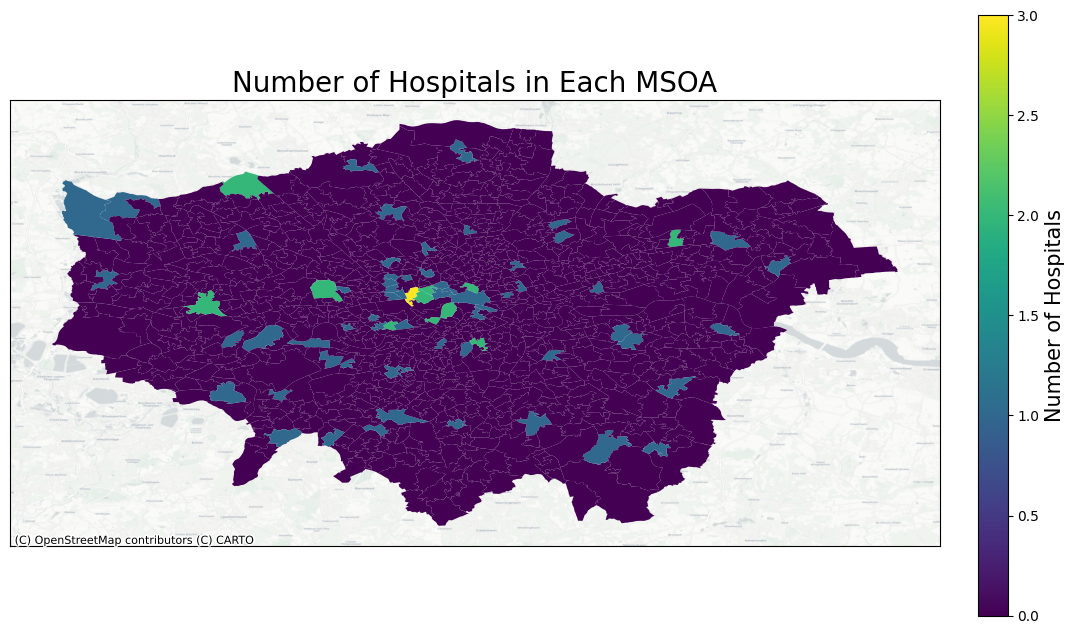

In [84]:
# map the hospitals in the msoa:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
msoa_shape.plot(column='hospitals_count', ax=ax, legend=True, cmap='viridis', legend_kwds={'label': "Number of Hospitals in MSOA"})
# make colorbar smaller
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel("Number of Hospitals", fontsize=15)

# Adjust colorbar size and position (New code)
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel("Number of Hospitals")
#cbar.ax.set_aspect(20)  # Increase aspect ratio to make it narrower
cbar.set_position([0.77, 0.2, 0.02, 0.6])  #



# Add basemap outside the area of interest
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs=msoa_shape.crs.to_string(),  # Ensure the CRS is correctly passed
    zoom=12
)



# Remove axis labels (coordinates)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
plt.title("Number of Hospitals in Each MSOA", fontsize=20)

plt.savefig(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/maps/msoa_hospital.tiff', dpi=350)

## 2.3 Find Each MSOA's Number of 20 min reachable hospitals:



In [116]:
# filrter out the msoa with no hospitals:
msoa_shape_hospitals = msoa_shape[msoa_shape['hospitals_count'] > 0]

In [117]:
msoa_shape_hospitals.shape

(70, 8)

In [105]:
def ttm_handling(ttm, msoa_shape_hospitals):
    """
    Filters columns of a DataFrame containing travel times to hospitals based on the presence of MSOAs in another DataFrame.

    Args:
        ttm (pandas.DataFrame): DataFrame with travel times (columns) to hospitals, indexed by MSOA21 IDs.
        msoa_shape_hospitals (pandas.DataFrame): DataFrame containing hospital information with an 'msoa21cd' column.

    Returns:
        pandas.DataFrame: Filtered ttm DataFrame with only columns corresponding to MSOAs in msoa_shape_hospitals.
    """

    # Extract MSOA21 IDs from the index of ttm
    ttm_msoa_ids = set(ttm.index)  

    # Get the set of valid MSOAs present in both DataFrames
    valid_msoas = ttm_msoa_ids & set(msoa_shape_hospitals['msoa21cd'])

    # Convert the set of valid MSOAs to a list for indexing
    valid_msoas_list = list(valid_msoas)  # <-- Key change here

    # Filter columns in ttm based on the valid MSOAs
    filtered_ttm = ttm[valid_msoas_list]  # <-- Use the list for indexing
    return filtered_ttm


In [106]:
r5_o_to_hospitals = ttm_handling(r5TTM, msoa_shape_hospitals)
here_o_to_hospitals = ttm_handling(hereTTM, msoa_shape_hospitals)
osrm_o_to_hospitals = ttm_handling(osrm_TTM, msoa_shape_hospitals)

In [109]:
here_o_to_hospitals.shape

(1002, 70)

In [110]:
r5_o_to_hospitals.loc[:, 'number_of_hos_than_20mins'] = r5_o_to_hospitals.apply(lambda row: row[row < 1200].count(), axis=1)
here_o_to_hospitals.loc[:, 'number_of_hos_than_20mins'] = here_o_to_hospitals.apply(lambda row: row[row < 1200].count(), axis=1)
osrm_o_to_hospitals.loc[:, 'number_of_hos_than_20mins'] = osrm_o_to_hospitals.apply(lambda row: row[row < 1200].count(), axis=1)

/tmp/ipykernel_1706/2059724128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r5_o_to_hospitals.loc[:, 'number_of_hos_than_20mins'] = r5_o_to_hospitals.apply(lambda row: row[row < 1200].count(), axis=1)
/tmp/ipykernel_1706/2059724128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  here_o_to_hospitals.loc[:, 'number_of_hos_than_20mins'] = here_o_to_hospitals.apply(lambda row: row[row < 1200].count(), axis=1)
/tmp/ipykernel_1706/2059724128.py:3: SettingWithCopyWarning: 
A value is trying to be set on

In [111]:
r5_o_to_hospitals.shape

(1002, 71)

## Step 3. Compare the Performance Implications

In [153]:
# keep only the column number_of_hos_than_20mins:
r5_o_to_hospitals_result = r5_o_to_hospitals['number_of_hos_than_20mins']
here_o_to_hospitals_result = here_o_to_hospitals['number_of_hos_than_20mins']
osrm_o_to_hospitals_result = osrm_o_to_hospitals['number_of_hos_than_20mins']


In [154]:
# set the row index of r5_o_to_hospitals_result to a column:
r5_o_to_hospitals_result = r5_o_to_hospitals_result.reset_index()
here_o_to_hospitals_result = here_o_to_hospitals_result.reset_index()
osrm_o_to_hospitals_result = osrm_o_to_hospitals_result.reset_index()

In [155]:
r5_o_to_hospitals_result.head()

,originID,number_of_hos_than_20mins
0,E02000001,22
1,E02000002,5
2,E02000003,6
3,E02000004,3
4,E02000005,4


In [156]:
msoa_shape_copy

,hclnm,hclnmw,label,msoa21cd,msoa21nm,name,geometry,hospitals_count
3,Plumstead High Street,None,E92000001E12000007E09000011E02000318,E02000318,Greenwich 006,Greenwich 006,"POLYGON ((0.10187 51.48939, 0.10187 51.48938, ...",0
4,Fulham Broadway,None,E92000001E12000007E09000013E02000388,E02000388,Hammersmith and Fulham 017,Hammersmith and Fulham 017,"POLYGON ((-0.19250 51.48476, -0.19244 51.48469...",0
13,Streatham Vale,None,E92000001E12000007E09000022E02000652,E02000652,Lambeth 035,Lambeth 035,"POLYGON ((-0.13566 51.41806, -0.13566 51.41806...",0
15,Queen's Park Gardens,None,E92000001E12000007E09000033E02000963,E02000963,Westminster 004,Westminster 004,"POLYGON ((-0.20950 51.53214, -0.20945 51.53214...",0
20,Streatham Common,None,E92000001E12000007E09000022E02000651,E02000651,Lambeth 034,Lambeth 034,"POLYGON ((-0.11300 51.42301, -0.11319 51.42286...",0
...,...,...,...,...,...,...,...,...
6812,Cranham East,None,E92000001E12000007E09000016E02000481,E02000481,Havering 018,Havering 018,"POLYGON ((0.28341 51.57668, 0.28348 51.57658, ...",0
6822,Shadwell North,None,E92000001E12000007E09000030E02000885,E02000885,Tower Hamlets 022,Tower Hamlets 022,"POLYGON ((-0.04575 51.51316, -0.04564 51.51316...",0
6828,Corbett Estate,None,E92000001E12000007E09000023E02000674,E02000674,Lewisham 022,Lewisham 022,"POLYGON ((0.00438 51.44502, 0.00438 51.44501, ...",0
6837,Bayswater East,None,E92000001E12000007E09000033E02000975,E02000975,Westminster 016,Westminster 016,"POLYGON ((-0.17775 51.51834, -0.17785 51.51768...",0


In [ ]:
msoa_shape_copy = msoa_shape.copy()

In [162]:
msoa_shape_hospitals.head()

,hclnm,hclnmw,label,msoa21cd,msoa21nm,name,geometry,hospitals_count,number_of_hos_than_20mins_R5,number_of_hos_than_20mins_here,number_of_hos_than_20mins_osrm
0,Plumstead High Street,None,E92000001E12000007E09000011E02000318,E02000318,Greenwich 006,Greenwich 006,"POLYGON ((0.10187 51.48939, 0.10187 51.48938, ...",0,4,3,4
1,Fulham Broadway,None,E92000001E12000007E09000013E02000388,E02000388,Hammersmith and Fulham 017,Hammersmith and Fulham 017,"POLYGON ((-0.19250 51.48476, -0.19244 51.48469...",0,17,12,23
2,Streatham Vale,None,E92000001E12000007E09000022E02000652,E02000652,Lambeth 035,Lambeth 035,"POLYGON ((-0.13566 51.41806, -0.13566 51.41806...",0,7,4,9
3,Queen's Park Gardens,None,E92000001E12000007E09000033E02000963,E02000963,Westminster 004,Westminster 004,"POLYGON ((-0.20950 51.53214, -0.20945 51.53214...",0,17,10,22
4,Streatham Common,None,E92000001E12000007E09000022E02000651,E02000651,Lambeth 034,Lambeth 034,"POLYGON ((-0.11300 51.42301, -0.11319 51.42286...",0,8,4,8


In [157]:
r5_o_to_hospitals_result = r5_o_to_hospitals_result.rename(columns={'originID': 'msoa21cd'})

# Merge the DataFrames
msoa_shape_hospitals = msoa_shape_copy.merge(
    r5_o_to_hospitals_result,
    on='msoa21cd',  # Use the common column name
    how='left',
    suffixes=('', '_R5')  # Ensure proper suffix handling for overlapping columns
)



,hclnm,hclnmw,label,msoa21cd,msoa21nm,name,geometry,hospitals_count,number_of_hos_than_20mins
0,Plumstead High Street,None,E92000001E12000007E09000011E02000318,E02000318,Greenwich 006,Greenwich 006,"POLYGON ((0.10187 51.48939, 0.10187 51.48938, ...",0,4
1,Fulham Broadway,None,E92000001E12000007E09000013E02000388,E02000388,Hammersmith and Fulham 017,Hammersmith and Fulham 017,"POLYGON ((-0.19250 51.48476, -0.19244 51.48469...",0,17
2,Streatham Vale,None,E92000001E12000007E09000022E02000652,E02000652,Lambeth 035,Lambeth 035,"POLYGON ((-0.13566 51.41806, -0.13566 51.41806...",0,7
3,Queen's Park Gardens,None,E92000001E12000007E09000033E02000963,E02000963,Westminster 004,Westminster 004,"POLYGON ((-0.20950 51.53214, -0.20945 51.53214...",0,17
4,Streatham Common,None,E92000001E12000007E09000022E02000651,E02000651,Lambeth 034,Lambeth 034,"POLYGON ((-0.11300 51.42301, -0.11319 51.42286...",0,8


In [158]:
# rename the column name to number_of_hos_than_20mins_R5
msoa_shape_hospitals = msoa_shape_hospitals.rename(columns={'number_of_hos_than_20mins': 'number_of_hos_than_20mins_R5'})

In [161]:
# do the same for here and osrm:
here_o_to_hospitals_result = here_o_to_hospitals_result.rename(columns={'originID': 'msoa21cd'})
osrm_o_to_hospitals_result = osrm_o_to_hospitals_result.rename(columns={'origin_msoaID': 'msoa21cd'})

msoa_shape_hospitals = msoa_shape_hospitals.merge(
    here_o_to_hospitals_result,
    on='msoa21cd',  # Use the common column name
    how='left',
    suffixes=('', '_HERE')  # Ensure proper suffix handling for overlapping columns
)
msoa_shape_hospitals = msoa_shape_hospitals.rename(columns={'number_of_hos_than_20mins': 'number_of_hos_than_20mins_here'})
msoa_shape_hospitals = msoa_shape_hospitals.merge(
    osrm_o_to_hospitals_result,
    on='msoa21cd',  # Use the common column name
    how='left',
    suffixes=('', '_OSRM')  # Ensure proper suffix handling for overlapping columns
)
msoa_shape_hospitals = msoa_shape_hospitals.rename(columns={'number_of_hos_than_20mins': 'number_of_hos_than_20mins_osrm'})

In [144]:
# describe the three columns: number_of_hos_than_20mins_r5	number_of_hos_than_20mins_here	number_of_hos_than_20mins_osrm
msoa_shape_hospitals.head()

,hclnm,hclnmw,label,msoa21cd,msoa21nm,name,geometry,hospitals_count,number_of_hos_than_20mins
3,Plumstead High Street,None,E92000001E12000007E09000011E02000318,E02000318,Greenwich 006,Greenwich 006,"POLYGON ((0.10187 51.48939, 0.10187 51.48938, ...",0,4
4,Fulham Broadway,None,E92000001E12000007E09000013E02000388,E02000388,Hammersmith and Fulham 017,Hammersmith and Fulham 017,"POLYGON ((-0.19250 51.48476, -0.19244 51.48469...",0,17
13,Streatham Vale,None,E92000001E12000007E09000022E02000652,E02000652,Lambeth 035,Lambeth 035,"POLYGON ((-0.13566 51.41806, -0.13566 51.41806...",0,7
15,Queen's Park Gardens,None,E92000001E12000007E09000033E02000963,E02000963,Westminster 004,Westminster 004,"POLYGON ((-0.20950 51.53214, -0.20945 51.53214...",0,17
20,Streatham Common,None,E92000001E12000007E09000022E02000651,E02000651,Lambeth 034,Lambeth 034,"POLYGON ((-0.11300 51.42301, -0.11319 51.42286...",0,8


In [165]:
msoa_shape_hospitals.head()

,hclnm,hclnmw,label,msoa21cd,msoa21nm,name,geometry,hospitals_count,number_of_hos_than_20mins_R5,number_of_hos_than_20mins_here,number_of_hos_than_20mins_osrm
0,Plumstead High Street,None,E92000001E12000007E09000011E02000318,E02000318,Greenwich 006,Greenwich 006,"POLYGON ((0.10187 51.48939, 0.10187 51.48938, ...",0,4,3,4
1,Fulham Broadway,None,E92000001E12000007E09000013E02000388,E02000388,Hammersmith and Fulham 017,Hammersmith and Fulham 017,"POLYGON ((-0.19250 51.48476, -0.19244 51.48469...",0,17,12,23
2,Streatham Vale,None,E92000001E12000007E09000022E02000652,E02000652,Lambeth 035,Lambeth 035,"POLYGON ((-0.13566 51.41806, -0.13566 51.41806...",0,7,4,9
3,Queen's Park Gardens,None,E92000001E12000007E09000033E02000963,E02000963,Westminster 004,Westminster 004,"POLYGON ((-0.20950 51.53214, -0.20945 51.53214...",0,17,10,22
4,Streatham Common,None,E92000001E12000007E09000022E02000651,E02000651,Lambeth 034,Lambeth 034,"POLYGON ((-0.11300 51.42301, -0.11319 51.42286...",0,8,4,8


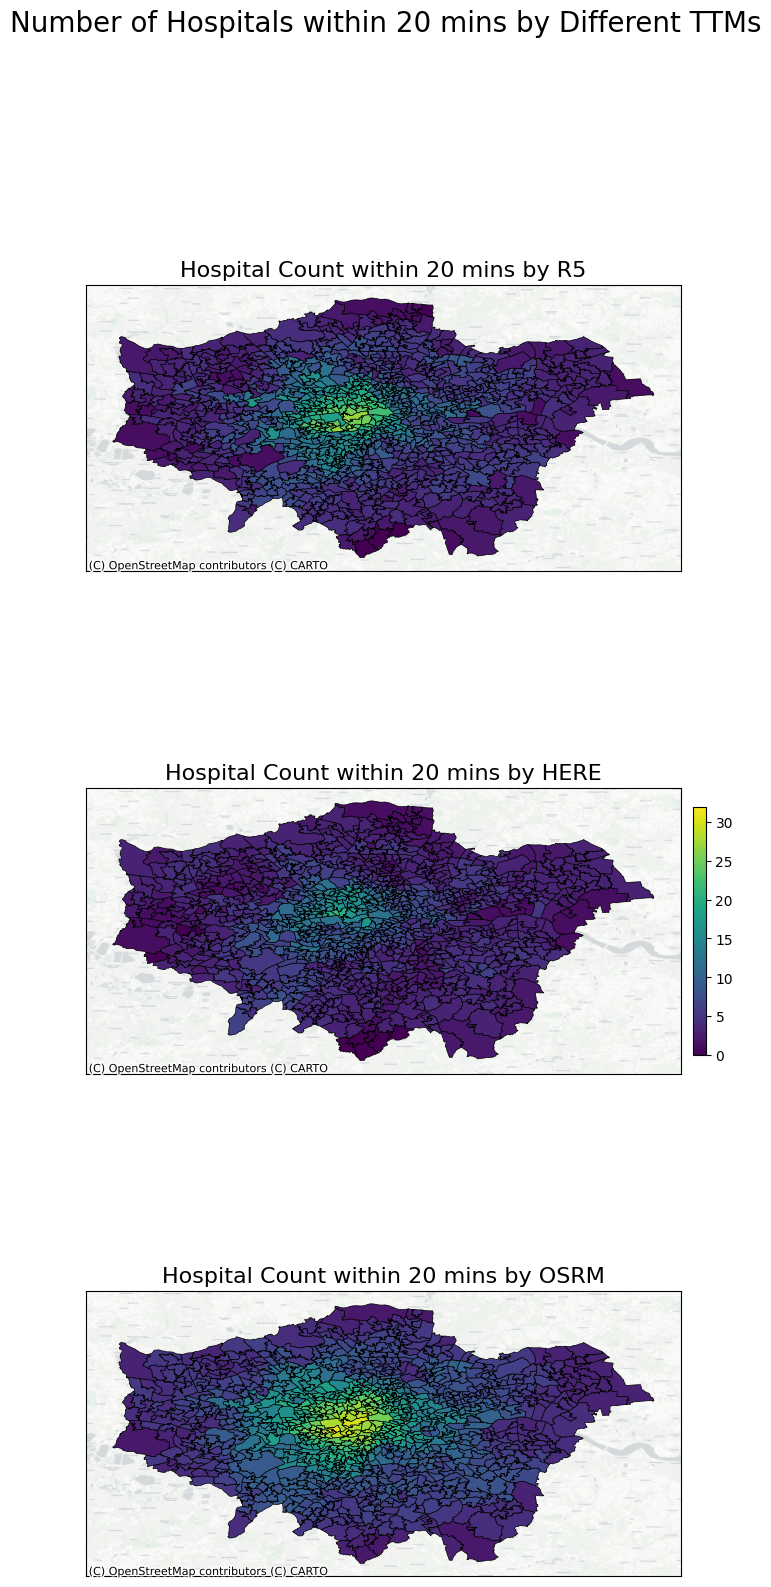

In [171]:
columns = ['number_of_hos_than_20mins_R5', 'number_of_hos_than_20mins_here', 'number_of_hos_than_20mins_osrm']
titles = ['Hospital Count within 20 mins by R5', 'Hospital Count within 20 mins by HERE', 'Hospital Count within 20 mins by OSRM']

vmax = msoa_shape_hospitals[['number_of_hos_than_20mins_R5', 'number_of_hos_than_20mins_here', 'number_of_hos_than_20mins_osrm']].max().max()
vmin = msoa_shape_hospitals[['number_of_hos_than_20mins_R5', 'number_of_hos_than_20mins_here', 'number_of_hos_than_20mins_osrm']].min().min()

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 19))
# Adjust the spacing between subplots
fig.subplots_adjust(wspace=0.00005, hspace=0.1)
# Flatten axes for easy iteration
axes = axes.flatten()

counter = 0 
for ax, column in zip(axes, columns):
    msoa_shape_hospitals.plot(
        ax=ax,
        column=column,
        #cmap='RdYlGn',
        cmap = 'viridis',
        vmin=vmin,
        vmax=vmax,
        legend=False,  # Disable individual legends
        edgecolor='black',
        linewidth=0.5
    )
    # Add basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.Positron,
        crs=msoa_shape.crs.to_string(),
        zoom=12
    )
    # Remove axis labels (coordinates)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    # Add a title for each subplot
    ax.set_title(titles[counter],fontsize=16)
    counter += 1


# Remove axis labels (coordinates)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])


#custom_cmap
fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax)), ax=axes, orientation='vertical', fraction=0.02, pad=0.02)


plt.suptitle("Number of Hospitals within 20 mins by Different TTMs", fontsize=20)
plt.savefig(r'/mnt/d/University College London/Chen, Huanfa - Dissertation_Mengyu_Ding/Data/maps/msoa_hospital_ttm_num_of_hos.tiff', dpi=350)

plt.show()